In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm


%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnectedLayer, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10, batchnorm=False, dropout=False):
        super(Encoder, self).__init__()
        self.conv1 = ConvLayer([1, 16, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        self.fc1 = FullyConnectedLayer([32*7*7, latent_size], dropout=dropout)
    
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 32*7*7)
        x = self.fc1(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10, dropout=False):
        super(Decoder, self).__init__()
        self.fc1 = FullyConnectedLayer([latent_size, 50, 28*28], dropout=dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = x.view(int(x.shape[0]/2), -1)
        return x

In [7]:
class NetAeConv(nn.Module):
    def __init__(self, latent_size=10, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(NetAeConv, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size, batchnorm, dropout)
        self.D = Decoder(latent_size, dropout)
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss


In [8]:
ae_models = {'bn': NetAeConv(10, batchnorm=True), 'drop': NetAeConv(10, batchnorm=False, dropout=True), 'plain': NetAeConv(10)}
train_log = {k: [] for k in ae_models}
test_log = {k: [] for k in ae_models}

In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)            
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [10]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [11]:
def run_models(models, n_epochs):
    for epoch in range(1, n_epochs+1):
        for model in models.values():
            model.train()
        train(epoch, models, train_log)
        for model in models.values():
            model.eval()
        test(models, valid_loader, test_log)

In [12]:
run_models(ae_models, 20)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 7.423355 drop: 7.409555 plain: 7.446188
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 5.053879 drop: 6.196976 plain: 4.871904
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 3.671547 drop: 5.252640 plain: 3.742043
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 3.327933 drop: 4.385144 plain: 3.301517
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 3.165788 drop: 3.964797 plain: 3.174073
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 2.799976 drop: 3.669785 plain: 3.102463
Test set:
bn: Loss: 2.7881	Accuracy: 1131.0/10000 (11%)
drop: Loss: 3.0404	Accuracy: 860.0/10000 (9%)
plain: Loss: 3.0997	Accuracy: 1131.0/10000 (11%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 2.812390 drop: 3.592934 plain: 3.114936
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 2.591555 drop: 3.421630 plain: 2.986225
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 2.499708 drop: 3.359212 plain: 2.642317
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 2.439700 drop: 3.383822 plain: 2.5189

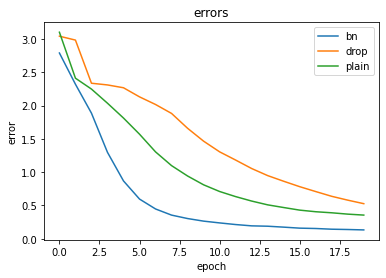

In [13]:
plot_graphs(test_log, 'loss')

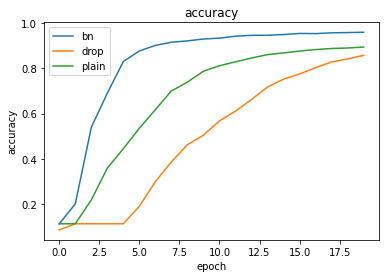

In [14]:
plot_graphs(test_log, 'accuracy')

In [15]:
# Классификатор
class NetClassifier(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(NetClassifier, self).__init__()
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnectedLayer([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [16]:
classif_models = {'bn': NetClassifier(True), 'drop': NetClassifier(False, True), 'plain': NetClassifier()}
train_log = {k: [] for k in classif_models}
test_log = {k: [] for k in classif_models}

In [17]:
run_models(classif_models, 10)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.244864 drop: 2.309003 plain: 2.274539
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.664586 drop: 2.275159 plain: 2.294804
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.181228 drop: 2.164953 plain: 2.219390
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 0.851821 drop: 1.784739 plain: 1.884026
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.789684 drop: 1.444281 plain: 1.557560
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.555142 drop: 0.960636 plain: 1.016980
Test set:
bn: Loss: 0.5398	Accuracy: 9163.0/10000 (92%)
drop: Loss: 0.9500	Accuracy: 8155.0/10000 (82%)
plain: Loss: 1.0244	Accuracy: 7948.0/10000 (79%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.465425 drop: 0.868319 plain: 0.945252
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.506412 drop: 0.793764 plain: 0.841824
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.463512 drop: 0.685136 plain: 0.718941
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.446155 drop: 0.690727 plain: 0.72

In [18]:
###########################################################
# Оптимизация картинки под функцию потерь (классификатор) #
###########################################################

In [19]:
# перевод модели в режим inference [вывод предсказаний]
for model in classif_models.values():
    model.eval()

In [20]:
device = torch.device("cpu")

In [21]:
def optimize_image_by_class(model, class_number, num_steps=5000):
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1,28,28))*0.001
    image = image.to(device)
    image.requires_grad = True
    
    # задайте оптимизатор
    # вы можете выбрать какой вам больше нравится
    optim = torch.optim.Adam([image], lr=1e-4)
    
    # задайте лосс функцию соответствующую заданию
    # лосс должен зависеть от class_number
    loss_fn = F.nll_loss
    grads = []
    losses = []
    for i in tqdm.tqdm(range(num_steps)):
        # здесь в цикле оптимизируется картинка
        # в оптимизатор передается ваш лосс и выход из модели
        # не забывайте обнулять градиенты с optim.zero_grad()
        # также полезно сохранять значения лосс функции и нормы градиента на каждом шаге
        # чтобы было видно как меняются эти значения в процессе "обучения" картинки.
        optim.zero_grad()
        output = model(image.unsqueeze(0))
        loss = loss_fn(F.log_softmax(output), torch.tensor([class_number]))
        loss.backward()
        grads.append(loss.grad)
        losses.append(loss)
        optim.step()
    
    # возвращаете картинку, grads, losses
    return image, grads, losses

In [22]:
num_classes = 10
logs = [{k: [] for k in classif_models}] * num_classes
final_images = []
final_grads = []
for class_number in range(num_classes):
    class_images = {}
    class_grads = {}
    for model in classif_models.items():
        key, value = model
        image, grads, losses = optimize_image_by_class(value, class_number)
        class_images[key] = image
        class_grads[key] = grads
        for loss in losses:
            logs[class_number][key].append((loss, None))
    final_images.append(class_images)
    final_grads.append(class_grads)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
100%|██████████| 5000/5000 [00:12<00:00, 392.93it/s]


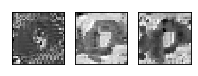

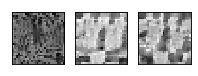

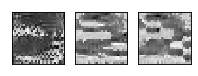

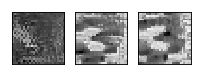

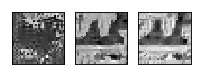

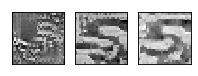

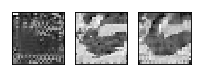

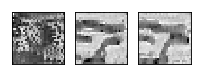

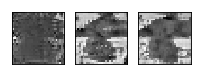

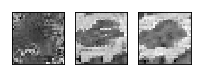

In [23]:
  for class_images in final_images:
      images = []
      for k, image in class_images.items():
          image = image.view(-1, 1, 28, 28)
          images.append(image)
      to_plot = torch.cat(images, dim=0).data.numpy()
      plot_mnist(to_plot, (1, 10))

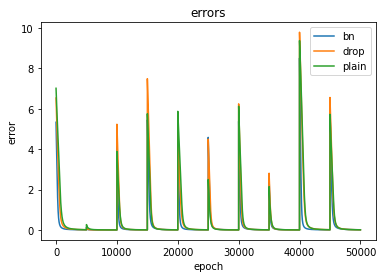

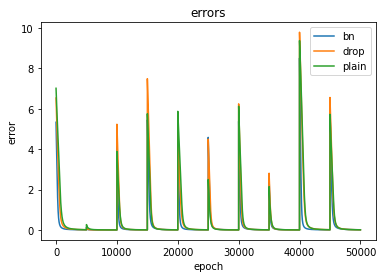

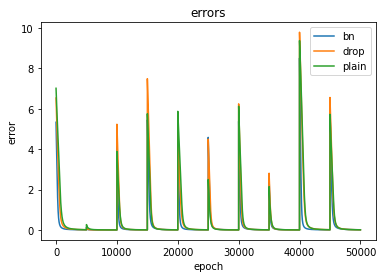

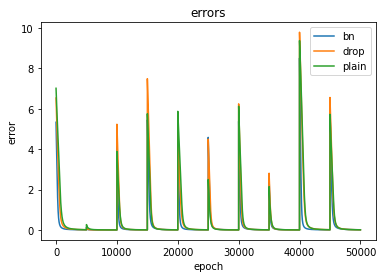

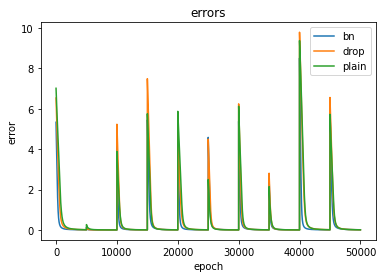

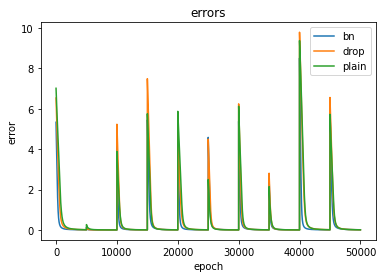

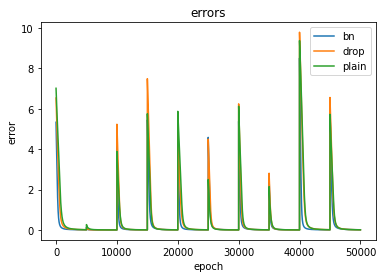

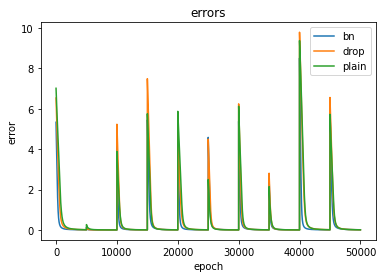

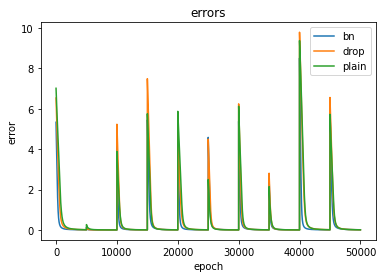

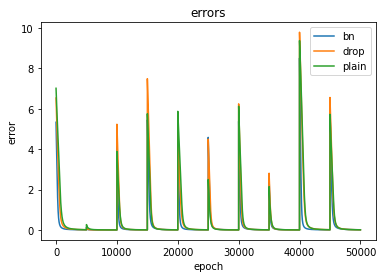

In [24]:
for class_number in range(num_classes):
    plot_graphs(logs[class_number], 'loss')

In [25]:
############################################################
# Оптимизация картинки под функцию потерь (автокодировщик) #
############################################################

In [26]:
for model in ae_models.values():
    model.eval()

In [27]:
def optimize_image_by_image(model, target_image, num_steps=10000):
    # создаем тензор, который будем оптимизировать
    image = torch.randn((1,28,28))*0.001
    image = image.to(device)
    image.requires_grad = True
    
    optim = torch.optim.Adam([image], lr=1e-4)
    
    loss_fn = F.mse_loss
    grads = []
    losses = []
    for i in tqdm.tqdm(range(num_steps)):
        optim.zero_grad()
        output = model(image.unsqueeze(0))
        output = output.view(-1, 28, 28)
        loss = loss_fn(output, target_image)
        loss.backward()
        grads.append(loss.grad)
        losses.append(loss)
        optim.step()
    
    # возвращаете картинку, grads, losses
    return image, grads, losses

In [28]:
ae_log = {k: [] for k in ae_models}
ae_final_images = {}
ae_final_grads = {}
data, _ = next(iter(test_loader))
data = torch.unsqueeze(data[0], 0) # первая картинка из батча
for model in ae_models.items():
    key, value = model
    image, grads, losses = optimize_image_by_image(value, data)
    ae_final_images[key] = image
    ae_final_grads[key] = grads
    for loss in losses:
        ae_log[key].append((loss, None))

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([2, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
100%|██████████| 10000/10000 [00:18<00:00, 528.59it/s]


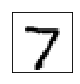

In [29]:
# Source image
to_plot = data.numpy()
plot_mnist(to_plot, (1, 1))

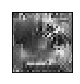

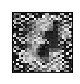

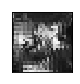

In [30]:
# Optimized images
for k, image in ae_final_images.items():
    to_plot = image.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 1))

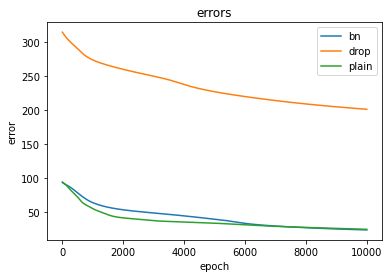

In [31]:
plot_graphs(ae_log, 'loss')